## JobInformatica Assignment

Environment setup and packages installation.

In [1]:
# ! pip install pandas seaborn statsmodels pmdarima tensorflow

In [3]:
import os
import datetime

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

import tensorflow as tf

SEED = 1234

SEARCH_SARIMAX_PARAMETERS = False
FIT_SARIMAX_MODEL = False

pd.set_option('display.max_columns', 500)

dataset_path = os.path.join('dataset', 'factory.csv')
saved_models_path = os.path.join('saved_models')
sarimax_models_path = os.path.join(saved_models_path, 'sarimax_model')

SARIMAX_MODEL_NAME = 'sarimax'

if not os.path.exists(saved_models_path):
	os.mkdir(saved_models_path)

if not os.path.exists(sarimax_models_path):
	os.mkdir(sarimax_models_path)

2024-04-19 19:31:42.322329: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Exploratory Data Analysis

In this section we will load the dataset and analyze it from an overall point of view to understand the kind of data we're dealing with.

In [4]:
energy_consumption_df = pd.read_csv(filepath_or_buffer=dataset_path, sep='\t')
energy_consumption_df.head()

,time_batch,cnc_average_kw,work_stations_average_kw,temp_CNC_1,humidity_CNC_1,temp_CNC_2,humidity_CNC_2,temp_CNC_3,humidity_CNC_3,temp_CNC_4,humidity_CNC_4,temp_CNC_5,humidity_CNC_5,temp_CNC_6,humidity_CNC_6,temp_CNC_7,humidity_CNC_7,temp_CNC_8,humidity_CNC_8,temp_CNC_9,humidity_CNC_9,temp_outside,press_mm_hg_outside,humidity_outside,windspeed_outside,visibility_outside,dewpoint_outside,temp_CNC_10,humidity_CNC_10
0,11-01-2016 17:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,11-01-2016 17:10,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,11-01-2016 17:20,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,11-01-2016 17:30,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.25,733.8,92.0,6.000000,51.500000,5.0,45.410390,45.410390
4,11-01-2016 17:40,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.13,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [5]:
energy_consumption_df.columns

Index(['time_batch', 'cnc_average_kw', 'work_stations_average_kw',
       'temp_CNC_1', 'humidity_CNC_1', 'temp_CNC_2', 'humidity_CNC_2',
       'temp_CNC_3', 'humidity_CNC_3', 'temp_CNC_4', 'humidity_CNC_4',
       'temp_CNC_5', 'humidity_CNC_5', 'temp_CNC_6', 'humidity_CNC_6',
       'temp_CNC_7', 'humidity_CNC_7', 'temp_CNC_8', 'humidity_CNC_8',
       'temp_CNC_9', 'humidity_CNC_9', 'temp_outside', 'press_mm_hg_outside',
       'humidity_outside', 'windspeed_outside', 'visibility_outside',
       'dewpoint_outside', 'temp_CNC_10', 'humidity_CNC_10'],
      dtype='object')

In [6]:
energy_consumption_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   time_batch                19735 non-null  object 
 1   cnc_average_kw            19735 non-null  int64  
 2   work_stations_average_kw  19735 non-null  int64  
 3   temp_CNC_1                19735 non-null  float64
 4   humidity_CNC_1            19735 non-null  float64
 5   temp_CNC_2                19735 non-null  float64
 6   humidity_CNC_2            19735 non-null  float64
 7   temp_CNC_3                19735 non-null  float64
 8   humidity_CNC_3            19735 non-null  float64
 9   temp_CNC_4                19735 non-null  float64
 10  humidity_CNC_4            19735 non-null  float64
 11  temp_CNC_5                19735 non-null  float64
 12  humidity_CNC_5            19735 non-null  float64
 13  temp_CNC_6                19735 non-null  float64
 14  humidi

In [7]:
energy_consumption_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cnc_average_kw,19735.0,97.694958,102.524891,10.000000,50.000000,60.000000,100.000000,1080.000000
work_stations_average_kw,19735.0,3.801875,7.935988,0.000000,0.000000,0.000000,0.000000,70.000000
temp_CNC_1,19735.0,21.686571,1.606066,16.790000,20.760000,21.600000,22.600000,26.260000
humidity_CNC_1,19735.0,40.259739,3.979299,27.023333,37.333333,39.656667,43.066667,63.360000
temp_CNC_2,19735.0,20.341219,2.192974,16.100000,18.790000,20.000000,21.500000,29.856667
humidity_CNC_2,19735.0,40.420420,4.069813,20.463333,37.900000,40.500000,43.260000,56.026667
temp_CNC_3,19735.0,22.267611,2.006111,17.200000,20.790000,22.100000,23.290000,29.236000
humidity_CNC_3,19735.0,39.242500,3.254576,28.766667,36.900000,38.530000,41.760000,50.163333
temp_CNC_4,19735.0,20.855335,2.042884,15.100000,19.530000,20.666667,22.100000,26.200000
humidity_CNC_4,19735.0,39.026904,4.341321,27.660000,35.530000,38.400000,42.156667,51.090000


From the pandas dataset description all the values seem inside their expected range.

Let's check missing values and duplicated rows.

In [8]:
num_duplicates = energy_consumption_df.duplicated(subset=['time_batch']).sum()

print(f'Number of duplicated records based on dates: {num_duplicates}')

Number of duplicated records based on dates: 0


From the datasets info() output we can see that there no missing values but we double check.

In [9]:
missing_values_total = energy_consumption_df.isna().sum()

print(f'Number of missing values: {missing_values_total}')
print(f'Total sum: {missing_values_total.sum()}')

Number of missing values: time_batch                  0
cnc_average_kw              0
work_stations_average_kw    0
temp_CNC_1                  0
humidity_CNC_1              0
temp_CNC_2                  0
humidity_CNC_2              0
temp_CNC_3                  0
humidity_CNC_3              0
temp_CNC_4                  0
humidity_CNC_4              0
temp_CNC_5                  0
humidity_CNC_5              0
temp_CNC_6                  0
humidity_CNC_6              0
temp_CNC_7                  0
humidity_CNC_7              0
temp_CNC_8                  0
humidity_CNC_8              0
temp_CNC_9                  0
humidity_CNC_9              0
temp_outside                0
press_mm_hg_outside         0
humidity_outside            0
windspeed_outside           0
visibility_outside          0
dewpoint_outside            0
temp_CNC_10                 0
humidity_CNC_10             0
dtype: int64
Total sum: 0


Convert the date format to datetime to enable handling of the data as a time-series.

In [10]:
energy_consumption_df['date'] = pd.to_datetime(energy_consumption_df['time_batch'], format='%d-%m-%Y %H:%M')
energy_consumption_df[['date']].describe()

,date
count,19735
mean,2016-03-20 05:30:00
min,2016-01-11 17:00:00
25%,2016-02-14 23:15:00
50%,2016-03-20 05:30:00
75%,2016-04-23 11:45:00
max,2016-05-27 18:00:00


We can see that the data spans from 2016-01-11 17:00:00 to 2016-05-27 18:00:00. Let's check that it has a uniform distribution in time. If it has an uniform distribution we should count 19735 10 minutes time intervals between the minimum date and maximum date.

In [11]:
# Extract the max and min dates from the datasets, not the cleanest code but it could change with future 
# versions of pandas
max_date = energy_consumption_df[['date']].max().dt.to_pydatetime().tolist()[0]
min_date = energy_consumption_df[['date']].min().dt.to_pydatetime().tolist()[0]

# Compute the time delta between the initial and the final date
time_difference = max_date - min_date

# Convert the time delta in seconds, then in minutes and finally in 10 minutes deltas
total_minutes = time_difference.total_seconds() / 60
total_10min_deltas = total_minutes / 10

print(f'Expected 10 minutes time intervals: {total_10min_deltas}')

Expected 10 minutes time intervals: 19734.0


/var/folders/ql/3j5kp265003_ty83733q2wt80000gn/T/ipykernel_70894/1473397053.py:3: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  max_date = energy_consumption_df[['date']].max().dt.to_pydatetime().tolist()[0]
/var/folders/ql/3j5kp265003_ty83733q2wt80000gn/T/ipykernel_70894/1473397053.py:4: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  min_date = energy_consumption_df[['date']].min().dt.to_pydatetime().tolist()[0]


The computed time intervals are equivalent to the records of the datasets if we consider that the starting or the ending record are exluded from the computation.

### Data Visualization

Now that we know that the data has a uniform distribution in time, we can plot the time-series and check if they show some patterns.

In [12]:
# Set the date as the dataframe index, execute only once as it will delete the column and 
# make it the dataframe index
energy_consumption_df.set_index('date', inplace=True)

# Drop the 'time_batch' to avoid data handling error when computing the energy consumed on average for each time of the day
energy_consumption_df.drop('time_batch', axis=1, inplace=True)

#### Daily Energy

Considering the long time span contained in dataset, visualizing the entire dataset in the same graph might not display insightful information. In the first steps we try to visualize a couple days of energy consumption comparing the ```cnc_average_kw``` and ```work_station_average_kw```.

<Axes: xlabel='date'>

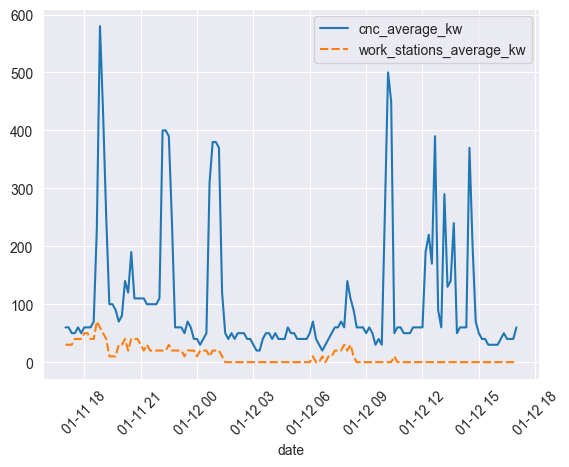

In [13]:
sns.set_style("darkgrid")

plt.xticks(rotation=45)
sns.lineplot(data=energy_consumption_df[['cnc_average_kw', 'work_stations_average_kw']]['2016-01-11 17:00':'2016-01-12 17:00'])

From the graph we can already see that there is a little correlation between the ```cnc_average_kw``` and ```work_station_average_kw``` but it needs to be checked with more detail.

We could analyze the data with a different sampling step to check if there is some sort of seasonal trend.

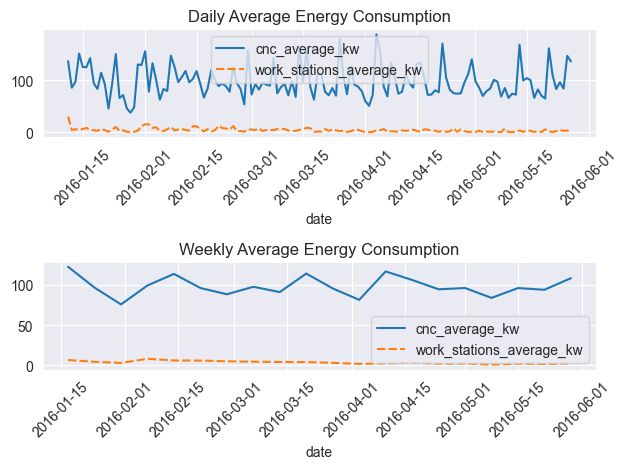

In [14]:
# Resample to daily frequency and compute mean for each day
daily_avg = energy_consumption_df[['cnc_average_kw', 'work_stations_average_kw']].resample('D').mean()

sns.set_style("darkgrid")

plt.subplot(2, 1, 1)  # 2 rows, 1 column, plot 1
plt.title('Daily Average Energy Consumption')
plt.xticks(rotation=45)
sns.lineplot(data=daily_avg)

# Resample to daily frequency and compute mean for each day
weekly_avg = energy_consumption_df[['cnc_average_kw', 'work_stations_average_kw']].resample('W').mean()

plt.subplot(2, 1, 2)  # 2 rows, 1 column, plot 2
plt.title('Weekly Average Energy Consumption')
plt.xticks(rotation=45)
sns.lineplot(data=weekly_avg)

plt.tight_layout()  # Adjust layout to prevent overlapping titles
plt.show()

From the graphs we can see that the data does not show any particular monthly or weekly seasonal trend. This could have been expected considering that the objective of the assignment is to find a prediction based on the 1 to 4 hours previous data.

Let's check in more detailed with precise instruments. (source: https://www.youtube.com/watch?v=7Np6Y1MHr0E)

(array([16813., 16815., 16817., 16819., 16821., 16823., 16825., 16827.,
        16829., 16831., 16832.]),
 [Text(16813.0, 0, '2016-01-13'),
  Text(16815.0, 0, '2016-01-15'),
  Text(16817.0, 0, '2016-01-17'),
  Text(16819.0, 0, '2016-01-19'),
  Text(16821.0, 0, '2016-01-21'),
  Text(16823.0, 0, '2016-01-23'),
  Text(16825.0, 0, '2016-01-25'),
  Text(16827.0, 0, '2016-01-27'),
  Text(16829.0, 0, '2016-01-29'),
  Text(16831.0, 0, '2016-01-31'),
  Text(16832.0, 0, '2016-02-01')])

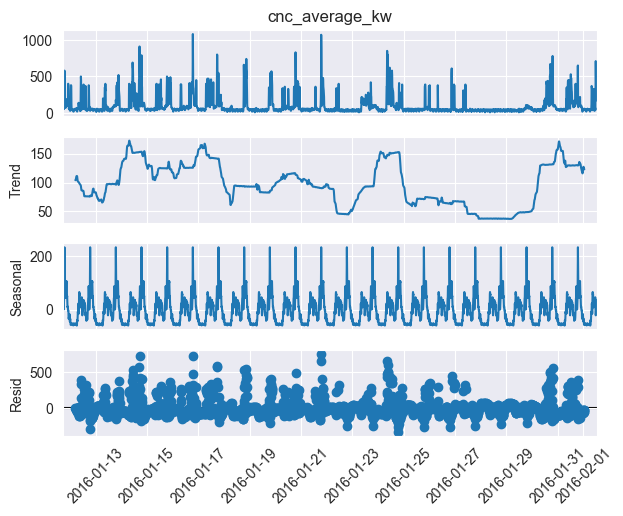

In [15]:
# Let's check in the first 3000 time steps if there's some seasonality
res = seasonal_decompose(energy_consumption_df['cnc_average_kw'][:3000], period=6*24)

res.plot()
plt.xticks(rotation=45)

From the seasonality analysis above we can see that there's a changing trend in energy consumption but there's a repeating seasonal pattern every day.

Let's try to plot daily trends by computing the mean values of all the days 10 minutes time intervals.

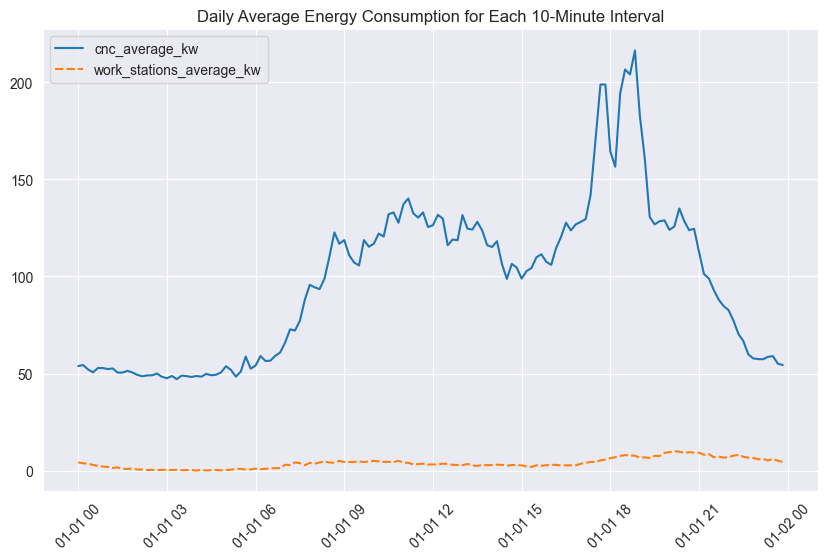

In [16]:
# Extract hour and minute from the timestamp
energy_consumption_df['hour'] = energy_consumption_df.index.hour
energy_consumption_df['minute'] = energy_consumption_df.index.minute

# Group by hour and minute, and compute the mean for each group
daily_avg_per_10min_df = energy_consumption_df.groupby(['hour', 'minute']).mean()

# Combine 'hour' and 'minute' indexes into a single datetime index
hour_minute_index = daily_avg_per_10min_df.index.get_level_values(0).astype(str) + ':' + daily_avg_per_10min_df.index.get_level_values(1).astype(str)
daily_avg_per_10min_df.index = pd.to_datetime(hour_minute_index, format='%H:%M')


# Plotting daily average energy consumption for each 10-minute interval
plt.figure(figsize=(10, 6))
sns.lineplot(data=daily_avg_per_10min_df[['cnc_average_kw', 'work_stations_average_kw']])
plt.title('Daily Average Energy Consumption for Each 10-Minute Interval')
plt.xticks(rotation=45)
plt.show()

This graph confirms the seasonality we found above and it is much more meaningful telling us that on average the energy consumption starts to increase in the morning, likely at the same time as the working shift, with a peak in the late afternoon and then lowers down again in the evening. It is important to notice that the energy consumption never goes to zero meaning that on average some of the machines are always working.

Seeing that the energy consumption has a daily seasonality suggest that the time of the day might be an important feature for the prediction model. In the next step we will try to encode the time of the day into a new feature to be used by the model.

#### Weather Data
In the next cells we'll analyze the environmental data in the datasets like temperature, humidity, windspeed and all the weather related data that might show some more sharp seasonal trends.

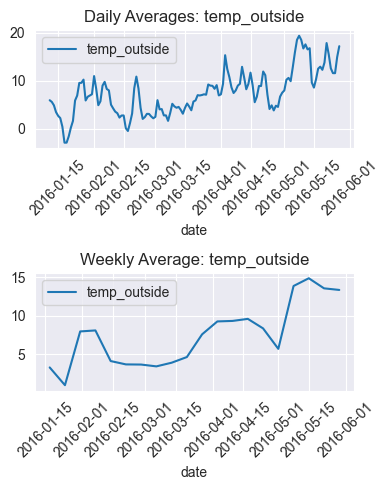

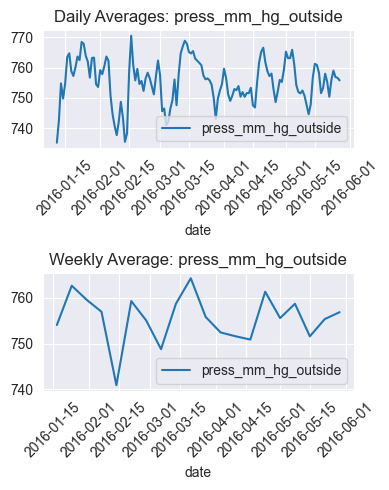

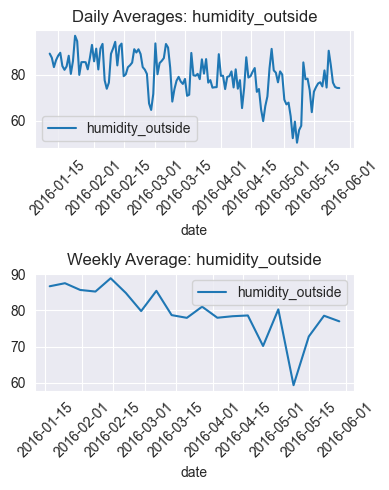

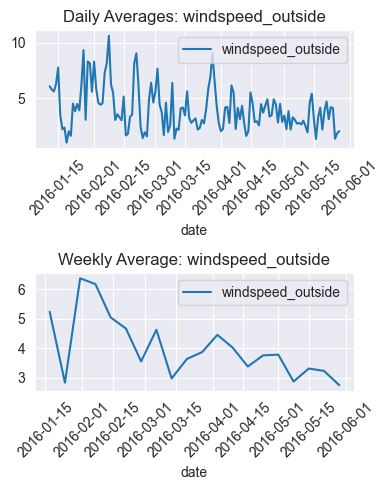

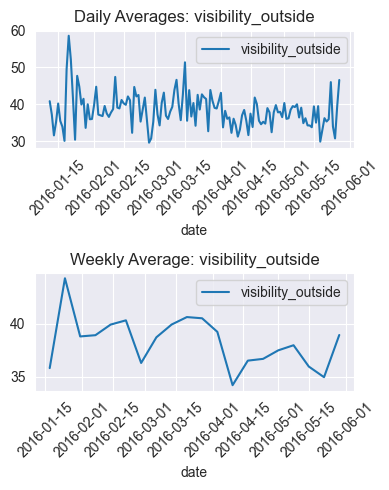

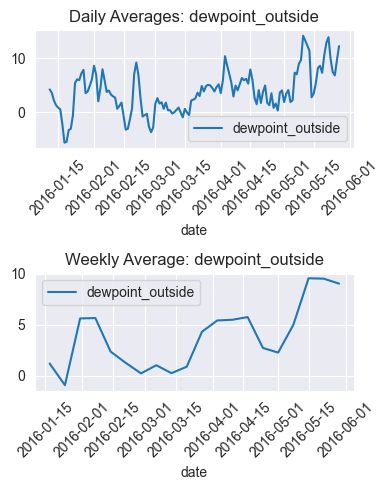

In [17]:
FIG_SIZE = (4, 5)

def plot_daily_weekly_avg(df: pd.DataFrame,
				 features: list[str],

				 ) -> None:
	# Resample to daily frequency and compute mean for each day
	daily_avg = df[features].resample('D').mean()

	sns.set_style("darkgrid")

	plt.figure(figsize=FIG_SIZE)

	plt.subplot(2, 1, 1)  # 2 rows, 1 column, plot 1
	plt.title(f'Daily Averages: {' '.join(features)}')
	plt.xticks(rotation=45)
	sns.lineplot(data=daily_avg)

	# Resample to daily frequency and compute mean for each day
	weekly_avg = df[features].resample('W').mean()

	plt.subplot(2, 1, 2)  # 2 rows, 1 column, plot 2
	plt.title(f'Weekly Average: {' '.join(features)}')
	plt.xticks(rotation=45)
	sns.lineplot(data=weekly_avg)

	plt.tight_layout()  # Adjust layout to prevent overlapping titles
	plt.show()


plot_daily_weekly_avg(df=energy_consumption_df, features=['temp_outside'])

plot_daily_weekly_avg(df=energy_consumption_df, features=['press_mm_hg_outside'])

plot_daily_weekly_avg(df=energy_consumption_df, features=['humidity_outside'])

plot_daily_weekly_avg(df=energy_consumption_df, features=['windspeed_outside'])

plot_daily_weekly_avg(df=energy_consumption_df, features=['visibility_outside'])

plot_daily_weekly_avg(df=energy_consumption_df, features=['dewpoint_outside'])


We can see that some features have a seasonal trends like temperature, humidity, dewpoint, and windspeed, while others have generally uniform distributed values across the considered time span.

In the next graph we'll analyze the temperature and humidity values of each CNC sensor.

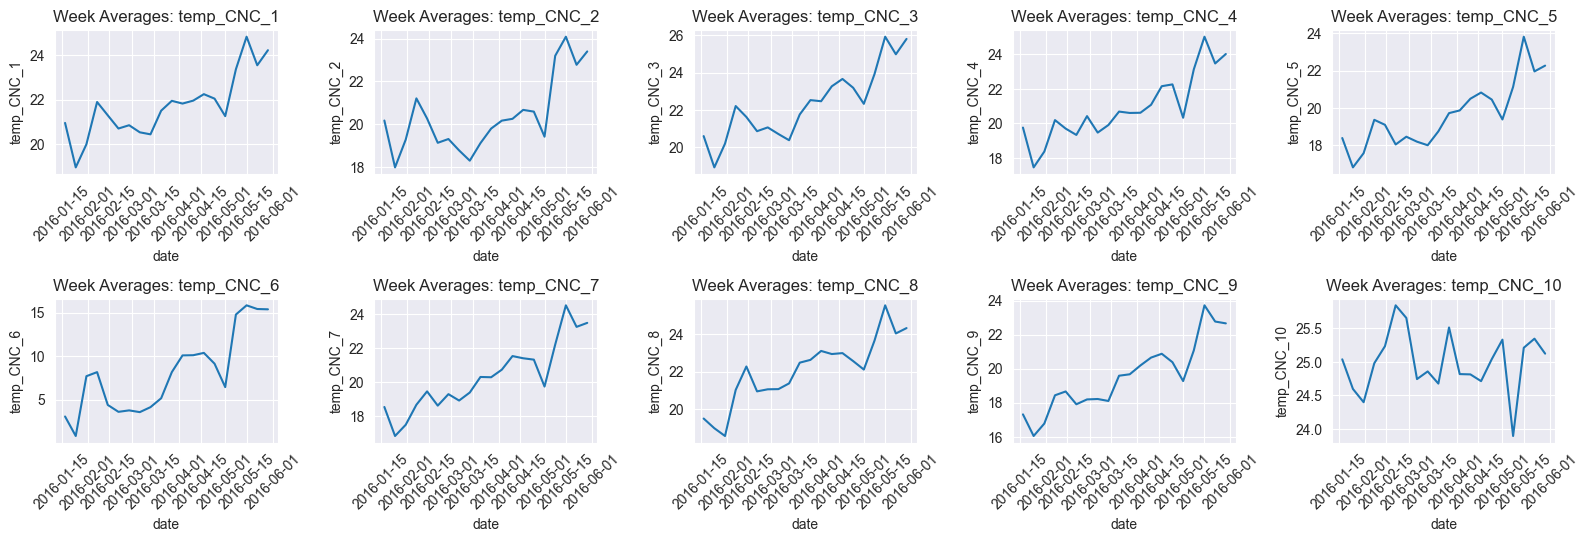

In [18]:
FIG_SIZE = (16, 10)

sns.set_style("darkgrid")

plt.figure(figsize=FIG_SIZE)

feature = 'temp_CNC_1'

# Resample to weekly frequency and compute mean for each week
week_avg = energy_consumption_df[feature].resample('W').mean()

plt.subplot(4, 5, 1)  
plt.title(f'Week Averages: {feature}')
plt.xticks(rotation=45)
sns.lineplot(data=week_avg)

feature = 'temp_CNC_2'

# Resample to weekly frequency and compute mean for each week
week_avg = energy_consumption_df[feature].resample('W').mean()

plt.subplot(4, 5, 2)  
plt.title(f'Week Averages: {feature}')
plt.xticks(rotation=45)
sns.lineplot(data=week_avg)

feature = 'temp_CNC_3'

# Resample to weekly frequency and compute mean for each week
week_avg = energy_consumption_df[feature].resample('W').mean()

plt.subplot(4, 5, 3)  
plt.title(f'Week Averages: {feature}')
plt.xticks(rotation=45)
sns.lineplot(data=week_avg)

feature = 'temp_CNC_4'

# Resample to weekly frequency and compute mean for each week
week_avg = energy_consumption_df[feature].resample('W').mean()

plt.subplot(4, 5, 4)  
plt.title(f'Week Averages: {feature}')
plt.xticks(rotation=45)
sns.lineplot(data=week_avg)

feature = 'temp_CNC_5'

# Resample to weekly frequency and compute mean for each week
week_avg = energy_consumption_df[feature].resample('W').mean()

plt.subplot(4, 5, 5)  
plt.title(f'Week Averages: {feature}')
plt.xticks(rotation=45)
sns.lineplot(data=week_avg)

feature = 'temp_CNC_6'

# Resample to weekly frequency and compute mean for each week
week_avg = energy_consumption_df[feature].resample('W').mean()

plt.subplot(4, 5, 6)  
plt.title(f'Week Averages: {feature}')
plt.xticks(rotation=45)
sns.lineplot(data=week_avg)

feature = 'temp_CNC_7'

# Resample to weekly frequency and compute mean for each week
week_avg = energy_consumption_df[feature].resample('W').mean()

plt.subplot(4, 5, 7)  
plt.title(f'Week Averages: {feature}')
plt.xticks(rotation=45)
sns.lineplot(data=week_avg)

feature = 'temp_CNC_8'

# Resample to weekly frequency and compute mean for each week
week_avg = energy_consumption_df[feature].resample('W').mean()

plt.subplot(4, 5, 8)  
plt.title(f'Week Averages: {feature}')
plt.xticks(rotation=45)
sns.lineplot(data=week_avg)

feature = 'temp_CNC_9'

# Resample to weekly frequency and compute mean for each week
week_avg = energy_consumption_df[feature].resample('W').mean()

plt.subplot(4, 5, 9)  
plt.title(f'Week Averages: {feature}')
plt.xticks(rotation=45)
sns.lineplot(data=week_avg)

feature = 'temp_CNC_10'

# Resample to weekly frequency and compute mean for each week
week_avg = energy_consumption_df[feature].resample('W').mean()

plt.subplot(4, 5, 10)  
plt.title(f'Week Averages: {feature}')
plt.xticks(rotation=45)
sns.lineplot(data=week_avg)

plt.tight_layout()  # Adjust layout to prevent overlapping titles

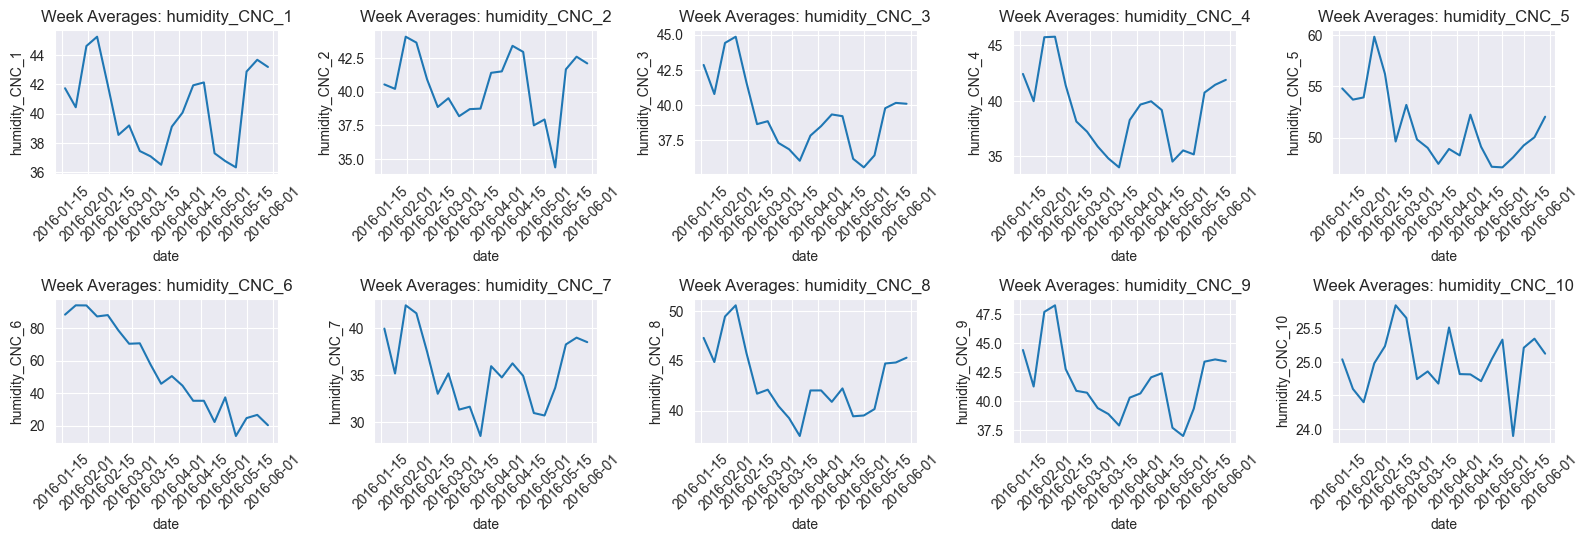

In [19]:
FIG_SIZE = (16, 10)

sns.set_style("darkgrid")

plt.figure(figsize=FIG_SIZE)

feature = 'humidity_CNC_1'

# Resample to weekly frequency and compute mean for each week
week_avg = energy_consumption_df[feature].resample('W').mean()

plt.subplot(4, 5, 1)  
plt.title(f'Week Averages: {feature}')
plt.xticks(rotation=45)
sns.lineplot(data=week_avg)

feature = 'humidity_CNC_2'

# Resample to weekly frequency and compute mean for each week
week_avg = energy_consumption_df[feature].resample('W').mean()

plt.subplot(4, 5, 2)  
plt.title(f'Week Averages: {feature}')
plt.xticks(rotation=45)
sns.lineplot(data=week_avg)

feature = 'humidity_CNC_3'

# Resample to weekly frequency and compute mean for each week
week_avg = energy_consumption_df[feature].resample('W').mean()

plt.subplot(4, 5, 3)  
plt.title(f'Week Averages: {feature}')
plt.xticks(rotation=45)
sns.lineplot(data=week_avg)

feature = 'humidity_CNC_4'

# Resample to weekly frequency and compute mean for each week
week_avg = energy_consumption_df[feature].resample('W').mean()

plt.subplot(4, 5, 4)  
plt.title(f'Week Averages: {feature}')
plt.xticks(rotation=45)
sns.lineplot(data=week_avg)

feature = 'humidity_CNC_5'

# Resample to weekly frequency and compute mean for each week
week_avg = energy_consumption_df[feature].resample('W').mean()

plt.subplot(4, 5, 5)  
plt.title(f'Week Averages: {feature}')
plt.xticks(rotation=45)
sns.lineplot(data=week_avg)

feature = 'humidity_CNC_6'

# Resample to weekly frequency and compute mean for each week
week_avg = energy_consumption_df[feature].resample('W').mean()

plt.subplot(4, 5, 6)  
plt.title(f'Week Averages: {feature}')
plt.xticks(rotation=45)
sns.lineplot(data=week_avg)

feature = 'humidity_CNC_7'

# Resample to weekly frequency and compute mean for each week
week_avg = energy_consumption_df[feature].resample('W').mean()

plt.subplot(4, 5, 7)  
plt.title(f'Week Averages: {feature}')
plt.xticks(rotation=45)
sns.lineplot(data=week_avg)

feature = 'humidity_CNC_8'

# Resample to weekly frequency and compute mean for each week
week_avg = energy_consumption_df[feature].resample('W').mean()

plt.subplot(4, 5, 8)  
plt.title(f'Week Averages: {feature}')
plt.xticks(rotation=45)
sns.lineplot(data=week_avg)

feature = 'humidity_CNC_9'

# Resample to weekly frequency and compute mean for each week
week_avg = energy_consumption_df[feature].resample('W').mean()

plt.subplot(4, 5, 9)  
plt.title(f'Week Averages: {feature}')
plt.xticks(rotation=45)
sns.lineplot(data=week_avg)

feature = 'humidity_CNC_10'

# Resample to weekly frequency and compute mean for each week
week_avg = energy_consumption_df[feature].resample('W').mean()

plt.subplot(4, 5, 10)  
plt.title(f'Week Averages: {feature}')
plt.xticks(rotation=45)
sns.lineplot(data=week_avg)

plt.tight_layout()  # Adjust layout to prevent overlapping titles

CNC temperature values do not show particular trends except for the standard seasonal temperature increase, excluding sensor 10 that has an overall steady temperature environment. On the other hand humidity values have quite different trends among different sensor, in the general picture the humidity always decreases with some exceptions like sensor 1 that reaches high values also in the final weeks and sensor 10 that has a steady trend like for the temperature.

From these observation we could speculate that sensor 10 is in a whole different place with respect to the other ones, maybe somewhere with a controlled temperature. Then, the CNC sensor from 1 to 9 could be located in the same space but in areas with different humidity levels that might be generated by the equipment used.

Some of this features could be reduced into a unique features to lower the dimension number when trying to predict the energy consumption and help the model generalize, however the small advantage introduced by reducing the dimensions might not be worth the effort so we will leave it for further studies.

### Feature Engineering

In the next we will create a new numerical feature that captures the time of the day. This feature should help the model understand which time of the day it is analyzing.

In [20]:
# Calculate the total number of minutes since the start of the day
energy_consumption_df['numerical_time_batch_minutes'] = energy_consumption_df.index.hour * 60 + energy_consumption_df.index.minute
energy_consumption_df['numerical_time_batch_minutes'].head()

date
2016-01-11 17:00:00    1020
2016-01-11 17:10:00    1030
2016-01-11 17:20:00    1040
2016-01-11 17:30:00    1050
2016-01-11 17:40:00    1060
Name: numerical_time_batch_minutes, dtype: int32

### Features Declaration

In the next cell we will declare the list of feature that we will use to predict the energy consumption and the target variable.

In [21]:
features_variables = ['work_stations_average_kw', 'temp_CNC_1', 'humidity_CNC_1', 
					  'temp_CNC_2', 'humidity_CNC_2', 'temp_CNC_3', 'humidity_CNC_3', 
					  'temp_CNC_4', 'humidity_CNC_4', 'temp_CNC_5', 'humidity_CNC_5', 
					  'temp_CNC_6', 'humidity_CNC_6', 'temp_CNC_7', 'humidity_CNC_7', 
					  'temp_CNC_8', 'humidity_CNC_8', 'temp_CNC_9', 'humidity_CNC_9', 
					  'temp_outside', 'press_mm_hg_outside', 'humidity_outside', 'windspeed_outside', 
					  'visibility_outside', 'dewpoint_outside', 'temp_CNC_10', 'humidity_CNC_10', 'numerical_time_batch_minutes']
target_variable = ['cnc_average_kw']

### Dataset Split

In [22]:
# Split the data into training and testing sets (e.g., 80% for training, 20% for testing)
train_size = int(len(energy_consumption_df) * 0.8)
train_data, test_data = energy_consumption_df.iloc[:train_size], energy_consumption_df.iloc[train_size:]

print(f'Training Dataset Size: {len(train_data)}\nTesting Dataset Size: {len(test_data)}')

Training Dataset Size: 15788
Testing Dataset Size: 3947


### Prediction

In the next paragraphs we will try to define a model to predict the energy consumption.

After doing some online research there are several models we could test for time-series predictions:
- Autoregressive Integrated Moving Average (ARIMA) and Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors (SARIMAX), which are more classic models for time series prediction.
- Long Short-Term Memory (LSTM) Networks and Gated Recurrent Units (GRU) Networks based on more modern Neural Network models which shoul be more powerful but consume more power and memory due to their complexity.
- Prophet, out-of-the-box model developed by Facebook that should be easy to use but might not be very customizable.

### ARIMA Model

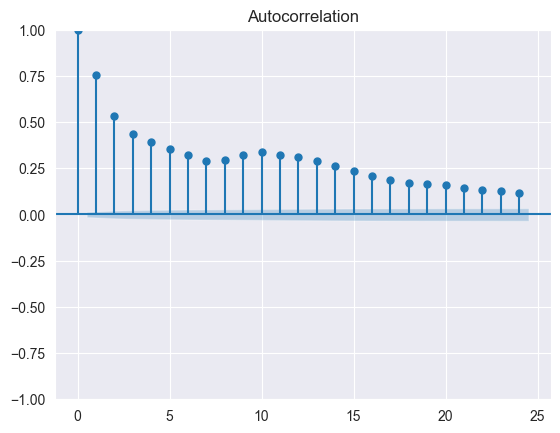

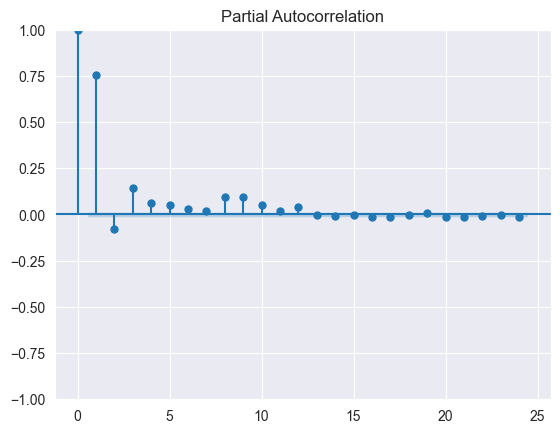

In [23]:
# Model Hyperparameters exploration
# Compute ACF and PACF
acf = plot_acf(energy_consumption_df[['cnc_average_kw']], lags=6*4)
pacf = plot_pacf(energy_consumption_df[['cnc_average_kw']], lags=6*4)

plt.show()

Based on the answers of ChatGPT, that should be double-checked but are reasonable as of now, if we observe peaks at lag 0 in both the ACF and PACF plots, it indicates that the time series may exhibit a strong trend or seasonality, but there may not be any significant autoregressive (AR) terms in the model beyond the immediate lag.

This observation agrees with the fact that the energy consumption alone has a strong daily seasonality, it is not a periodic function, but predicting its values based only on its previous observations might not be sufficient.

In the next cell we'll try to use a multivariate models that exploits other dataset features.

### SARIMAX Model

#### Optimal parameters search

We will use [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) to detect the best parameters to set up the sarimax model. (source: https://www.youtube.com/watch?v=7Np6Y1MHr0E)

In [24]:
# Lets find the optimal SARIMAX parameters
# Here we're considering 7 days periods to find a daily seasonality
if SEARCH_SARIMAX_PARAMETERS:
	auto_arima(energy_consumption_df[target_variable], exogenous=energy_consumption_df[features_variables],
			   m=7, trace=True).summary()

# Previous compilation result: SARIMAX(5, 0, 1)x(1, 0, [], 7) Required time 11m 32,2s

#### Model Definition

In [25]:
# Create the SARIMAX model
sarimax_model = SARIMAX(train_data[target_variable], exog=train_data[features_variables], order=(5, 0, 1), seasonal_order=(1, 0, [], 7))

/Users/lucianofranchin/miniconda3/envs/job_informatica_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/Users/lucianofranchin/miniconda3/envs/job_informatica_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)


#### Model Training

In [27]:
model_name = None

if FIT_SARIMAX_MODEL:
	fitted_model = sarimax_model.fit()

	model_name = os.path.join(sarimax_models_path, f'{SARIMAX_MODEL_NAME}_{datetime.datetime.now().strftime('%d_%m_%Y-%H_%M')}.pickle')
	fitted_model.save(model_name)

#### Testing

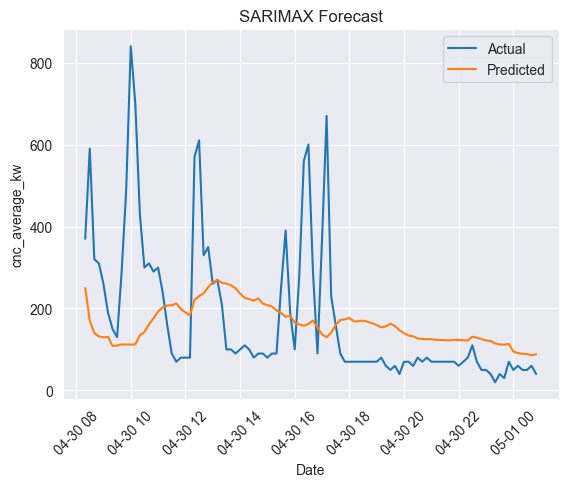

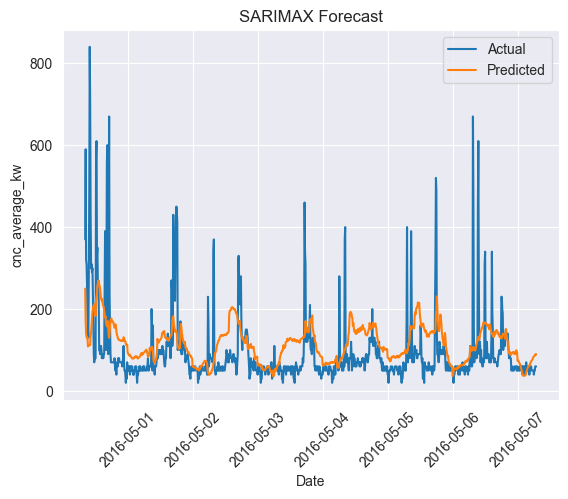

In [28]:
if model_name:
    fitted_model = SARIMAXResults.load(model_name)
else:
    model_name = max(os.listdir(sarimax_models_path))
    model_name = os.path.join(sarimax_models_path, model_name)
    fitted_model = SARIMAXResults.load(model_name)

# Make predictions for the next 10 time periods
forecast = fitted_model.forecast(steps=1000, exog=test_data[features_variables][:1000])

# Visualize the actual vs. predicted values
plt.plot(test_data[:100].index, test_data[target_variable][:100], label='Actual')
plt.plot(forecast[:100].index, forecast[:100], label='Predicted')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel(target_variable[0])
plt.title('SARIMAX Forecast')
plt.legend()
plt.show()

# Visualize the actual vs. predicted values
plt.plot(test_data[:1000].index, test_data[target_variable][:1000], label='Actual')
plt.plot(forecast.index, forecast, label='Predicted')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel(target_variable[0])
plt.title('SARIMAX Forecast')
plt.legend()
plt.show()

From the graph we can see that the performance of the model are not satisfactory but at least the time-series seasonality is captured by the model.

The model might need some finetuning that we will leave for further studies.

### LSTM Model

In this section we will try to use more powerful models based on neural network architectures.

### Datasets Preparation

#### Dataset Split

In [29]:
# https://www.tensorflow.org/tutorials/structured_data/time_series#split_the_data
n = len(energy_consumption_df)
train_df = energy_consumption_df[0:int(n*0.7)][features_variables + target_variable]
val_df = energy_consumption_df[int(n*0.7):int(n*0.9)][features_variables + target_variable]
test_df = energy_consumption_df[int(n*0.9):][features_variables + target_variable]

#### Data Normalization

In [30]:
# Data normalization https://www.tensorflow.org/tutorials/structured_data/time_series#normalize_the_data
train_mean = train_df[features_variables].mean()
train_std = train_df[features_variables].std()

train_df[features_variables] = (train_df[features_variables] - train_mean) / train_std
val_df[features_variables] = (val_df[features_variables] - train_mean) / train_std
test_df[features_variables] = (test_df[features_variables] - train_mean) / train_std

#### Windowing
Here we will define the function to create the windows of consecutives samples from the data.

In [40]:
class WindowGenerator():
	def __init__(self, 
			  	 input_width, 
				 label_width, 
				 shift,
			  	 train_df, 
				 val_df, 
				 test_df,
				 label_columns=None):
		# Store the raw data.
		self.train_df = train_df
		self.val_df = val_df
		self.test_df = test_df

		# Work out the label column indices.
		self.label_columns = label_columns
		if label_columns is not None:
			self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
		self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

		# Work out the window parameters.
		self.input_width = input_width
		self.label_width = label_width
		self.shift = shift

		self.total_window_size = input_width + shift

		self.input_slice = slice(0, input_width)
		self.input_indices = np.arange(self.total_window_size)[self.input_slice]

		self.label_start = self.total_window_size - self.label_width
		self.labels_slice = slice(self.label_start, None)
		self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
	
	@property
	def train(self):
		return self.make_dataset(self.train_df)
	
	@property
	def val(self):
		return self.make_dataset(self.val_df)
	
	@property
	def test(self):
		return self.make_dataset(self.test_df)

	@property
	def example(self):
		"""Get and cache an example batch of `inputs, labels` for plotting."""
		result = getattr(self, '_example', None)
		if result is None:
			# No example batch was found, so get one from the `.train` dataset
			result = next(iter(self.train))
			# And cache it for next time
			self._example = result
		return result

	def make_dataset(self, data):
		data = np.array(data, dtype=np.float32)
		ds = tf.keras.utils.timeseries_dataset_from_array(
			data=data,
			targets=None,
			sequence_length=self.total_window_size,
			sequence_stride=1,
			shuffle=True,
			batch_size=32,)
		ds = ds.map(self.split_window)
		return ds
	
	def split_window(self, features):
		inputs = features[:, self.input_slice, :]
		labels = features[:, self.labels_slice, :]
		if self.label_columns is not None:
			labels = tf.stack(
				[labels[:, :, self.column_indices[name]] for name in self.label_columns],
				axis=-1)

		# Slicing doesn't preserve static shape information, so set the shapes
		# manually. This way the `tf.data.Datasets` are easier to inspect.
		inputs.set_shape([None, self.input_width, None])
		labels.set_shape([None, self.label_width, None])
		
		return inputs, labels

	def plot(self, model=None, plot_col='cnc_average_kw', max_subplots=3):
		inputs, labels = self.example
		plt.figure(figsize=(12, 8))
		plot_col_index = self.column_indices[plot_col]
		max_n = min(max_subplots, len(inputs))
		for n in range(max_n):
			plt.subplot(max_n, 1, n+1)
			plt.ylabel(f'{plot_col}')
			plt.plot(self.input_indices, inputs[n, :, plot_col_index],
			label='Inputs', marker='.', zorder=-10)
		
			if self.label_columns:
				label_col_index = self.label_columns_indices.get(plot_col, None)
			else:
				label_col_index = plot_col_index
				
			if label_col_index is None:
				continue
		
			plt.scatter(self.label_indices, labels[n, :, label_col_index],
						edgecolors='k', label='Labels', c='#2ca02c', s=64)
			if model is not None:
				predictions = model(inputs)
				print(predictions.shape)
				print(self.label_indices.shape)
				plt.scatter(self.label_indices, predictions[n, :, label_col_index],
							marker='X', edgecolors='k', label='Predictions',
							c='#ff7f0e', s=64)
			
			if n == 0:
				plt.legend()
			
		plt.xlabel('Time [10min]')
	
	def __repr__(self):
		return '\n'.join([
			f'Total window size: {self.total_window_size}',
			f'Input indices: {self.input_indices}',
			f'Label indices: {self.label_indices}',
			f'Label column name(s): {self.label_columns}'])

#### Dataset Creation

All shapes are: (batch, time, features)
Window shape: (3, 25, 29)
Inputs shape: (3, 24, 29)
Labels shape: (3, 24, 1)


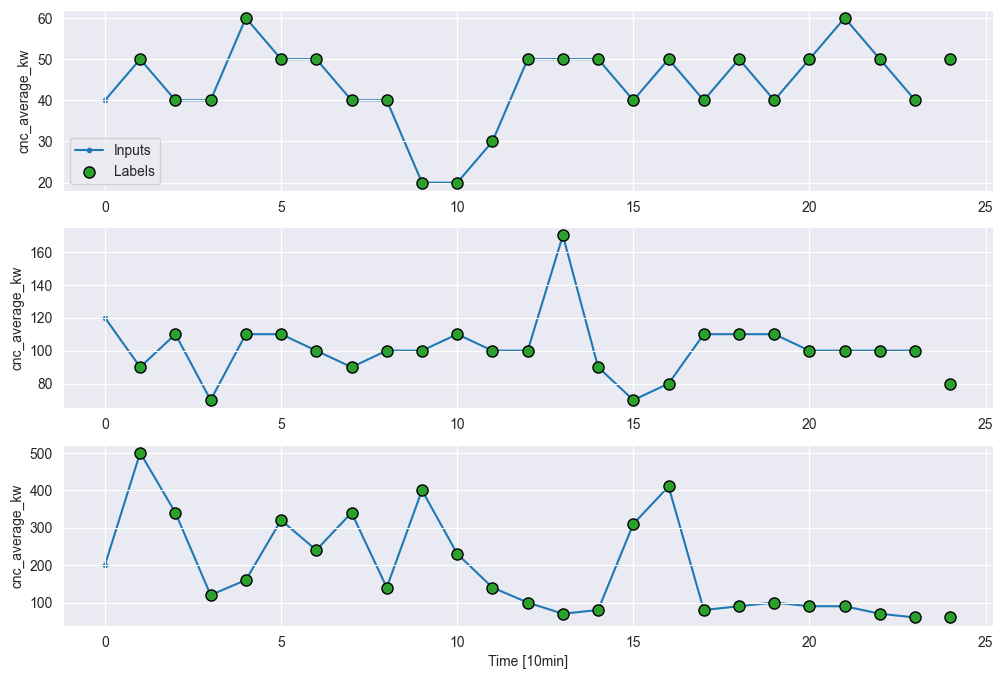

In [45]:
FOUR_HOUR = 6*4
TWO_HOUR = 6*2
ONE_HOUR = 6*1

w_gen = WindowGenerator(input_width=FOUR_HOUR,
						label_width=FOUR_HOUR,
						shift=1,
						train_df=train_df,
						val_df=val_df,
						test_df=test_df,
						label_columns=target_variable,
						)

# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w_gen.total_window_size]),
                           np.array(train_df[100:100+w_gen.total_window_size]),
                           np.array(train_df[200:200+w_gen.total_window_size])])

example_inputs, example_labels = w_gen.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

w_gen.plot()

#### Model Definition

In [46]:
LSTM_UNITS = 32

# Define the LSTM model
lstm_model = tf.keras.models.Sequential([
	# Shape [batch, time, features] => [batch, time, lstm_units]
	tf.keras.layers.LSTM(LSTM_UNITS, return_sequences=True),
	# Shape => [batch, time, features]
	tf.keras.layers.Dense(units=1)
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='mae')

#### Model Training

In [47]:
MAX_EPOCHS = 200
BATCH_SIZE = 32
PATIENCE = 15

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
												  patience=PATIENCE,
						  						  mode='min')

lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
				   optimizer=tf.keras.optimizers.Adam(),
				   metrics=[tf.keras.metrics.MeanAbsoluteError()])

history = lstm_model.fit(w_gen.train, 
						 epochs=MAX_EPOCHS,
						 validation_data=w_gen.val,
						 callbacks=[early_stopping])

Epoch 1/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 20462.8594 - mean_absolute_error: 93.4135 - val_loss: 12865.6348 - val_mean_absolute_error: 70.0820
Epoch 2/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 17133.5020 - mean_absolute_error: 74.0239 - val_loss: 11182.8955 - val_mean_absolute_error: 57.1759
Epoch 3/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 15321.0752 - mean_absolute_error: 62.5808 - val_loss: 9997.6855 - val_mean_absolute_error: 46.9189
Epoch 4/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 14199.7646 - mean_absolute_error: 55.5667 - val_loss: 9129.3193 - val_mean_absolute_error: 41.1180
Epoch 5/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 13188.5078 - mean_absolute_error: 50.9512 - val_loss: 8466.6660 - val_mean_absolute_error: 37.6339
Epoch 6/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 12244.6348 - mean_absolute_error: 47.6533 - val_loss: 7884.0806 - val_mean_absolute_error: 35.1237
Epoch 7/200
431/431 ━━━━━━━━━━━━━━━━━━

(32, 24, 1)
(24,)
(32, 24, 1)
(24,)
(32, 24, 1)
(24,)


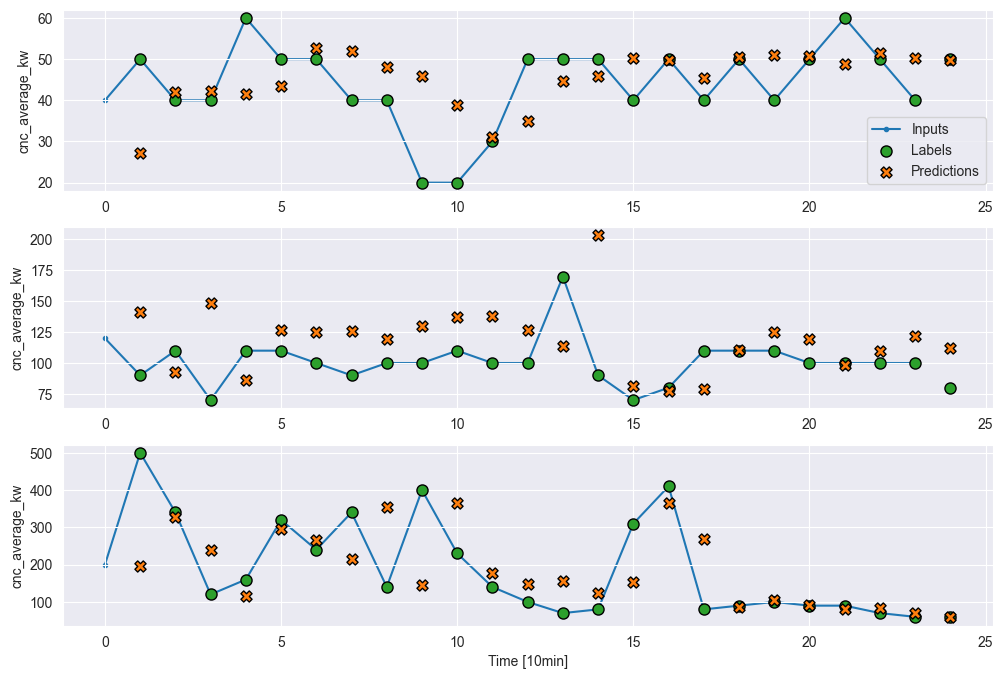

In [48]:
w_gen.plot(lstm_model)

#### TODO 
- Analyze the performance on longer time intervals.
- Analyze the performance with different time.windows.
- Implement auto-regressive models.